#  MIDS W207 

## Authors: Neha Kumar, Suhas Gupta
## Submission Data: 04/06/2019 

In [32]:
# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import json
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time

# SK-learn libraries for learning and preprocessing
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
# Set the figure size for seaborn plots
sns.set(rc={'figure.figsize':(20,20)})

We selected the SF Crime competition

https://www.kaggle.com/c/sf-crime/data

In [2]:
## Import CSV files into pandas data frames

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')


In [3]:
## Lets look at the train data frame
train[:5]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
## Look at the test data frame 
test[:5]

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


(from Kaggle)
## Data fields
- Dates - timestamp of the crime incident
- Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
- Descript - detailed description of the crime incident (only in train.csv)
- DayOfWeek - the day of the week
- PdDistrict - name of the Police Department District
- Resolution - how the crime incident was resolved (only in train.csv)
- Address - the approximate street address of the crime incident 
- X - Longitude
- Y - Latitude

The variables we can use to generate the model will need to be in both the train and test dataset. This gives us:
- Dates
- DayOfWeek
- PdDistrict
- Address
- X
- Y

Let us look at a quick summary of the dataset provided by Kaggle to check if there are any missing/NULL values in the data.

In [5]:
print('Training data set')
print('..................')
print(train.info())
print('\nTest data set')
print('..................')
print(test.info())

Training data set
..................
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB
None

Test data set
..................
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
Id            884262 non-null int64
Dates         884262 non-null object
DayOfWeek     884262 non-null object
PdDistrict    884262 non-null object
Address       884262 non-null object
X             884262 non-null float64
Y             884262 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47

- The output above shows that there are no missing values in the Kaggle datasets for both training and test data. Thus we do not need to account for missing values in our EDA and model development.

- We can also see from above, that all the variables except geographical coordinates (X,Y) are categorical. Thus we will need to perform feature encoding to enable the use of sklearn's modeling and prediction algorithms.

First let us examine the outcome variable "Category"

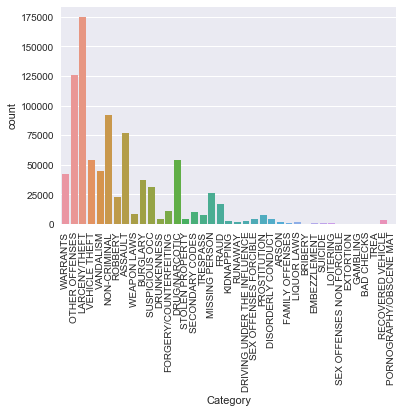

In [6]:
sns.countplot(data = train, x = 'Category',orient='h')
#g.set_xticklabels(g.get_xticklabels(),rotation=90)
tmp = plt.xticks(rotation=90)

The above plot shows the frequency distribution of the outcome variable **Category**. The distribution might appear to be skewed but this is expected since the outcome variable is categorical and cannot be sorted in a numerical order. We can see that the maximum frequency crime cateogry is **LARCENY/THEFT** followed by **OTHER OFFSENSES** and **NON-CRIMINAL**. Thus if the training data is unbiased and randomly distributed, we can expect a good accuracy score by just predicting outcome of 45% LARCENY, 35% OTHER and 20% NON-CRIMINAL in our test outcome vector. We will later see how this strategy performs as a prediction model.

As an additional note, we notice that some categories have very poor representation (particularly on the right hand sdie of this graph). This immediately discards KNN as a viable modeling option, as it would bias reponses to those that are over-represented (and have a larger number of neighbors).

In [7]:
train['Category'].value_counts()

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [8]:
train.drop(train.index[train['Category'] == 'PORNOGRAPHY/OBSCENE MAT'], inplace = True)
train.drop(train.index[train['Category'] == 'TREA'], inplace = True)
train['Category'].value_counts()

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [9]:
# Plot freq distributio, box plots and scatter plots of category versus independent variables 

cat_column_list = train.select_dtypes(include = 'object').columns.values
num_column_list = train.select_dtypes(include = 'float64').columns.values

train.describe(include='all')

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
count,878021,878021,878021,878021,878021,878021,878021,878021.000000,878021.000000
unique,389251,37,875,7,10,17,23228,NaN,NaN
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST,NaN,NaN
freq,185,174900,60022,133729,157178,526777,26532,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.422617,37.771020
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030354,0.456900
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.513642,37.707879
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.432952,37.752427
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.416420,37.775421
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.406959,37.784369


In [10]:
# Create a copy of the training dataset for feature engineering

train_v2 = train.copy()
test_v2 = test.copy()

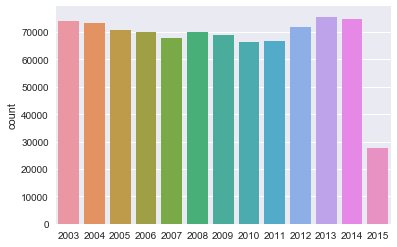

In [11]:
# Look at just the year in the Dates column
year_vals = (train_v2['Dates'].str.split('-').str[0]).values
(np.unique(year_vals))
g = sns.countplot(year_vals)

train_v2['year'] = (pd.to_numeric(train_v2['Dates'].str.split('-').str[0])).astype('int64')
test_v2['year'] = (pd.to_numeric(test_v2['Dates'].str.split('-').str[0])).astype('int64')

All the years appear to be evenly distributed in the data set, i.e. there is no distinction boundary apparent in the crime categories from just the year data.

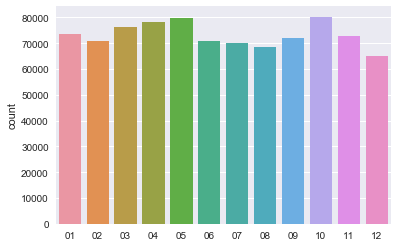

In [12]:
# Look at just the month in the Dates column
month_vals = (train['Dates'].str.split('-').str[1]).values
(np.unique(month_vals))
g = sns.countplot(month_vals)
train_v2['month'] = (pd.to_numeric(train_v2['Dates'].str.split('-').str[1])).astype('int64')
test_v2['month'] = (pd.to_numeric(test_v2['Dates'].str.split('-').str[1])).astype('int64')

In [13]:
test_v2[:5]

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y,year,month
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,2015,5
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,2015,5
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,2015,5
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015,5


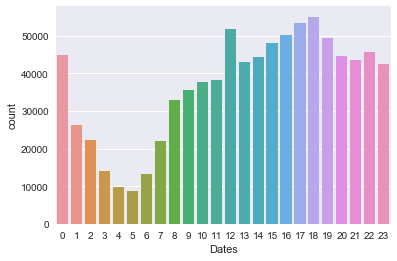

In [14]:
# Look at just the hour in the Dates column
hour_vals = pd.to_datetime(train['Dates'],infer_datetime_format=True).dt.hour
(np.unique(hour_vals))
g = sns.countplot(hour_vals)

train_v2['hour'] = (pd.to_datetime(train_v2['Dates'],infer_datetime_format=True).dt.hour).astype('float64')
test_v2['hour'] = (pd.to_datetime(test_v2['Dates'],infer_datetime_format=True).dt.hour).astype('float64')

To get the Zip Codes, we first tried to use geopy's reverse geocode mapping to get the full address (With the zipcode) from the lat/long coordinates. However, we were hitting into a "too many requests" error. Best practices recommend we make 1 request per second. As our training dataset has about 800k records, running this API will take close to 10 days. 

As a result, we pivoted to another strategy. Using the information here https://community.periscopedata.com/t/q5kqgg/us-zip-codes-with-latitudelongitude, we got a CSV with all of the lat/long coordinates cooresponding to each zip code. We then used k nearest neighbors with this CSV as the training dataset (with KNN = 1) to find the zip code whose lat/long coordinate is closest to the crime locatiom.

As a caveat, this assumes that zip codes are circular regions (when in reality they are irregularly shaped). However, this approximation runs much faster than using an API, so we will use this way of determining zip codes.

       zip_code   latitude   longitude
39798     94101  37.784827 -122.727802
39799     94102  37.779278 -122.416582
39800     94103  37.775678 -122.412131
39801     94104  37.790728 -122.401732
39802     94105  37.789595 -122.395631


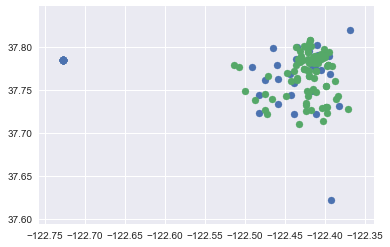

In [15]:
# Source of data https://community.periscopedata.com/t/q5kqgg/us-zip-codes-with-latitudelongitude
zips = pd.read_csv('zip_codes_states.csv')
sf_zips = zips[zips['city'] == 'San Francisco'][['zip_code','latitude','longitude']]

# Plotting the SF Zip code midpoints with some crime locations to ensure that the data pulled in via CSV makes ense
print(sf_zips[:5])
plt.scatter(sf_zips['longitude'],sf_zips['latitude'])
demo = train[:100]
plt.scatter(demo['X'],demo['Y'])

In [16]:
# Building a KNN Model with n_neighbors = 1 on the lat/long coordinates
zip_features = sf_zips[['longitude','latitude']]
zip_features.columns = ['X', 'Y']
zip_train = zip_features.values
zip_train_labels = sf_zips['zip_code'].values

zip_testtrain = train[['X','Y']].values

knn_zip = KNeighborsClassifier(n_neighbors = 1)
pred_zip = knn_zip.fit(zip_train, zip_train_labels).predict(zip_testtrain)

# Here, we put our predicted zip code into the training data frame
train_v2['zipcode'] = pred_zip
print(train_v2[:5])

# Doing the same for the test data
zip_testtest = test_v2[['X','Y']].values
pred_zip = knn_zip.fit(zip_train, zip_train_labels).predict(zip_testtest)
test_v2['zipcode'] = pred_zip
test_v2['zipcode'] = test_v2['zipcode'].astype('int64')
print(test_v2[:5])

                 Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  year  month  hour  zipcode  
0 -122.425892  37.774599  2015      5  23.0    94102  
1 -122.425892  37.774599  2015      

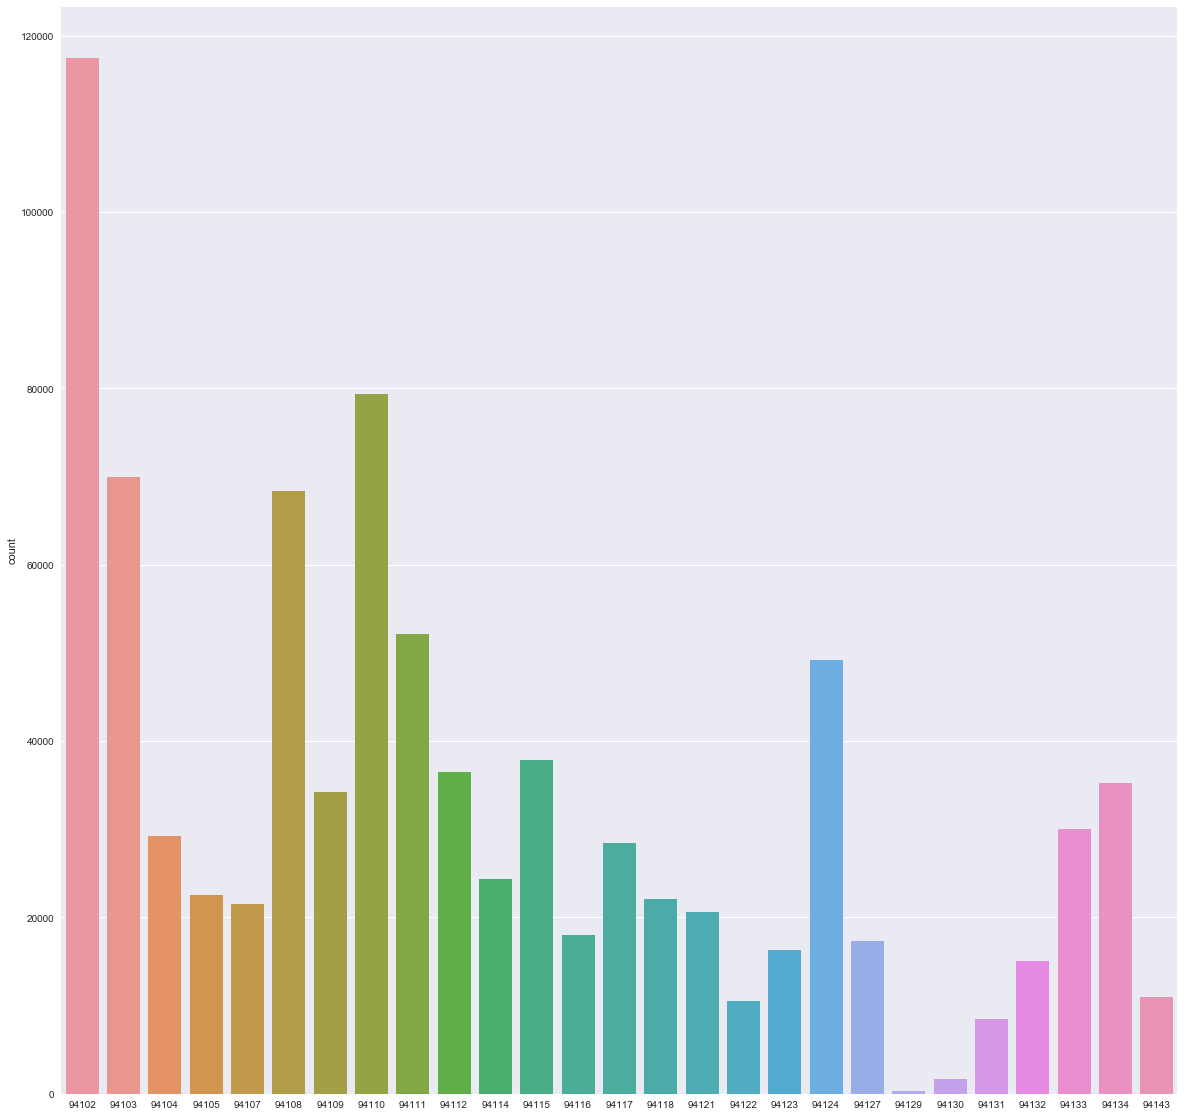

In [105]:
# Look at the distribution of zip codes
zips = train_v2['zipcode'].values
(np.unique(zips))
g = sns.countplot(zips)

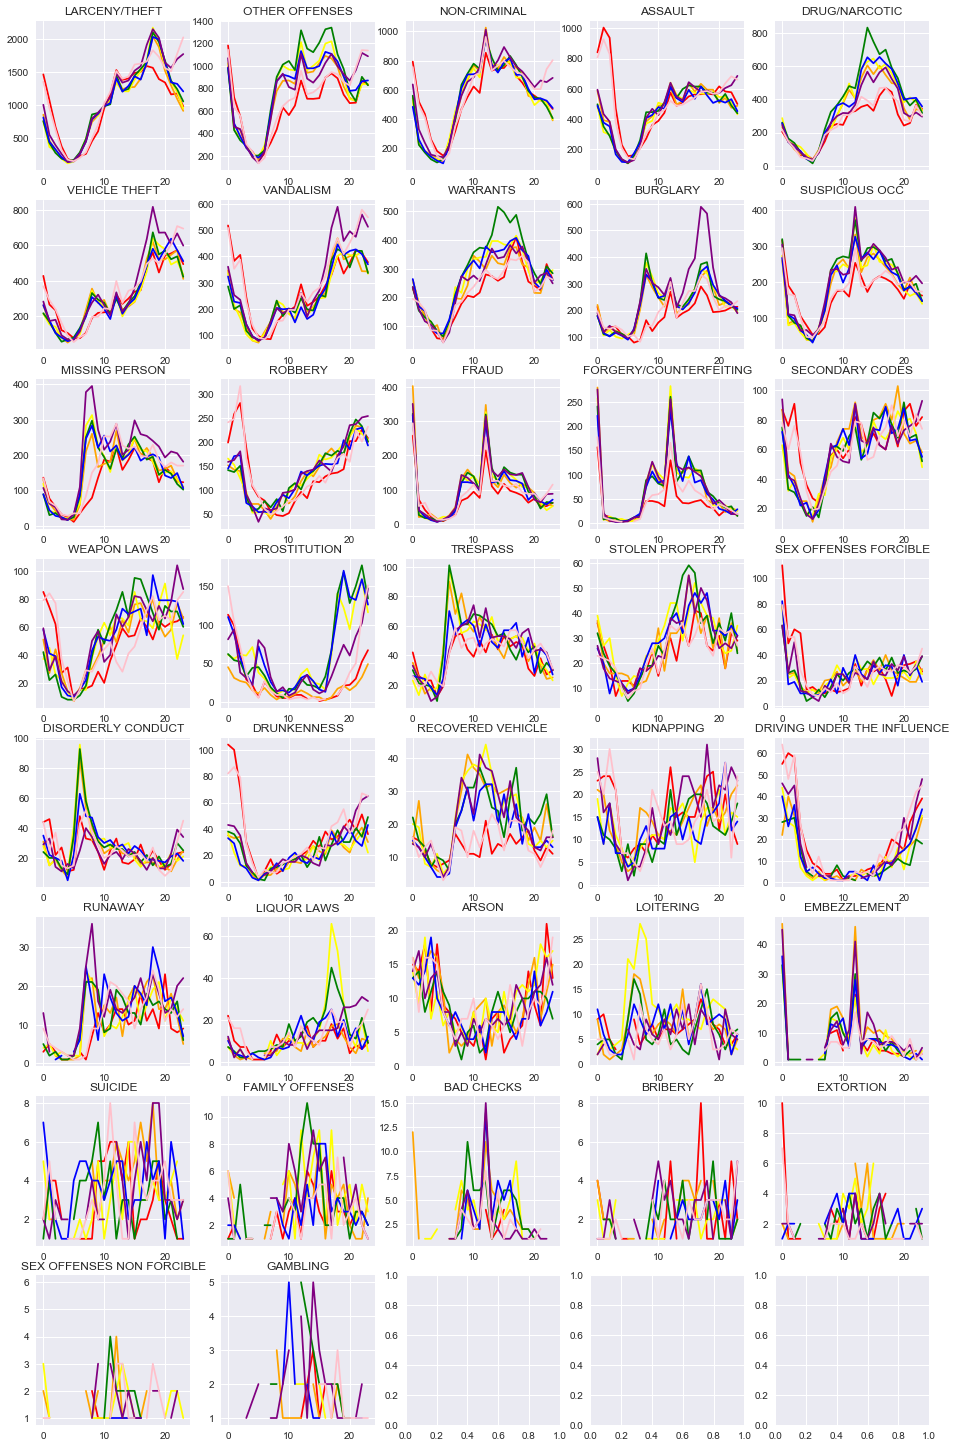

In [180]:
fig, axes = plt.subplots(nrows=8, ncols=5, sharex=False, sharey=False, figsize = (16, 20))
plt.subplots_adjust(top = 1.1)

all_categories = train_v2['Category'].value_counts().index.tolist()
for category in range(len(all_categories)):
    my_cat = all_categories[category]
    df = train_v2.loc[train_v2['Category'] == my_cat,:]
    df = df.groupby(['hour','DayOfWeek']).count()['X']
    df = df.reset_index(level='hour').reset_index(level = 'DayOfWeek')
    df = df.pivot(index='hour', columns='DayOfWeek', values='X').reset_index()
    
    ax = plt.subplot(8, 5, category + 1)
    
    hour = df['hour'].values
    sunday = df['Sunday'].values
    monday = df['Monday'].values
    tuesday = df['Tuesday'].values
    wednesday = df['Wednesday'].values
    thursday = df['Thursday'].values
    friday = df['Friday'].values
    saturday = df['Saturday'].values
    
    ax.plot(hour,sunday, 'red')
    ax.plot(hour,monday,'orange')
    ax.plot(hour,tuesday,'yellow')
    ax.plot(hour,wednesday,'green')
    ax.plot(hour,thursday,'blue')
    ax.plot(hour,friday,'purple')
    ax.plot(hour,saturday,'pink')
    
    ax.set_title(my_cat)



In [18]:
# Checking for US Holidays

# Load in holidays dataframe (source: https://www.kaggle.com/gsnehaa21/federal-holidays-usa-19662020)
holidays = pd.read_csv('usholidays.csv')
print(holidays[:5])

# Make is_holiday flag
dates_train = (train_v2['Dates'].str.split(' ').str[0])
dates_test = (test_v2['Dates'].str.split(' ').str[0])

train_v2['is_holiday'] = dates_train.isin(holidays.Date).astype(int)
test_v2['is_holiday'] = dates_test.isin(holidays.Date).astype(int)


proportion_holidays = train_v2['is_holiday'].sum() / train_v2.shape[0]
print('The proportion of crime records on US recognized holidays is', proportion_holidays)
print('The proportion of crime records NOT on US recognized holidays is', 1 - proportion_holidays)
print(train_v2[:5])
print(test_v2[:5])


   Unnamed: 0        Date                              Holiday
0           0  2010-12-31                       New Year's Day
1           1  2011-01-17  Birthday of Martin Luther King, Jr.
2           2  2011-02-21                Washington's Birthday
3           3  2011-05-30                         Memorial Day
4           4  2011-07-04                     Independence Day
The proportion of crime records on US recognized holidays is 0.02865648999283616
The proportion of crime records NOT on US recognized holidays is 0.9713435100071638
                 Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict 

In [19]:
## Deal with geo-coordinates
# Remove latitude of 90 degress (north pole)

train_v2 = train_v2[train_v2.Y < 90]
train_v2 = train_v2[train_v2.Y < 90]

In [20]:
train_v2.describe(include='all')

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,year,month,hour,zipcode,is_holiday
count,877954,877954,877954,877954,877954,877954,877954,877954.000000,877954.000000,877954.000000,877954.000000,877954.000000,877954.000000,877954.000000
unique,389223,37,875,7,10,17,23191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,185,174885,60013,133718,157170,526744,26532,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.422763,37.767035,2008.712390,6.436378,13.412761,94113.349555,0.028659
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025285,0.024165,3.631132,3.428993,6.549542,10.100971,0.166845
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.513642,37.707879,2003.000000,1.000000,0.000000,94102.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.432952,37.752427,2006.000000,3.000000,9.000000,94105.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.416420,37.775421,2009.000000,6.000000,14.000000,94110.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.406959,37.784368,2012.000000,9.000000,19.000000,94118.000000,0.000000


In [21]:
class createTestTrainData:
    '''
        Parameters: 
            trainDataFrame: Pandas DF containing training data
            testDataFrame: Pandas DF containing test data
            outcome : [String] Predicted variable name in the data frame
            removeCategories: [List] Categories to be removed from the training data frame to match test data shape
            trainDataEncoded: Numpy data array containing encoded feature set for training data
            trainlabelsEncoded: Numpy data array containing encoded dataset for training labels
            mini_size: Size of the mini training data and label set to create
            r_seed: Random seed for test train split 
            t_size: Size of dev dataset
            shuffle: Boolean indicating shuffling of data for test train split
            
        Methods: 
            getDataSets(): Converts the pandas data frames for test and training data to numpy arrays for modeling
            testTrainSplit(): Splits dataset into training and development data sets         

    '''
    def __init__(self,trainDataFrame=pd.DataFrame(),testDataFrame=pd.DataFrame(),outcome='Category',
                 removeCategoriesTrain=['Category','Descript','Resolution'],
                 removeCategoriesTest= ['Category','Descript','Resolution'],
                 trainDataEncoded=[],trainlabelsEncoded=[], 
                 mini_size = 1000, r_seed = 1, t_size = 0.20, shuffle=True):
        
        # Parameters for data set creation
        self._trainDataFrame = trainDataFrame
        self._testDataFrame = testDataFrame
        self._remCatsTrain = removeCategoriesTrain  # categories to remove from the training dataset
        self._remCatsTest = removeCategoriesTest  # categories to remove from the test dataset

        self._labelCat = outcome # define the outcome category
        
        # Parameters for test train data split
        self._r_seed = r_seed
        self._shuffle = shuffle
        self._t_size = t_size
        self._mini_size = mini_size
        self._encodedData = trainDataEncoded
        self._encodedLabels = trainlabelsEncoded
 
    def getDataSets(self):
        """ Process pandas dataframe and return numpy arrays """
        
        data_train_df = self._trainDataFrame.drop(self._remCatsTrain,axis=1)
        labels_train_df = pd.DataFrame(self._trainDataFrame, columns = [self._labelCat])

        ## Convert data frame to numpy arrays
        data_train = data_train_df.values
        labels_train = labels_train_df.values
        ## Store the feature names in a list
        train_features_names = list(data_train_df.keys())
        ## Remove ID column from test data
        self._testDataFrame = self._testDataFrame.drop(self._remCatsTest,axis=1)
        test_data = self._testDataFrame.values
        test_feature_names = list(self._testDataFrame.keys())
        
        return data_train,labels_train,test_data,train_features_names,test_feature_names
    
    def testTrainSplit(self):
        """ Split into training, dev and mini training data sets """
        train_data, dev_data, train_labels, dev_labels = train_test_split(self._encodedData, self._encodedLabels,test_size = self._t_size, random_state = self._r_seed,shuffle=self._shuffle)
        mini_train_data, mini_train_labels = train_data[:self._mini_size], train_labels[:self._mini_size]
        return train_data, dev_data, mini_train_data, train_labels, dev_labels, mini_train_labels
    

In [22]:
# Define a data pre processing class

class featureProcessor:
    '''
        Parameters: 
            dataset: Numpy array containing data with features and samples 
            encode: Boolean indicating encoding of data
            encodeScheme: String value indicating scheme to use for encoding 
 
        Methods: 
            encodeTrainData(): Encodes the data using encodeScheme and returns transformed datasets
            encodeLabels(): Encodes the labels using encodeScheme and returns transformed label sets and class names

    '''
    
    def __init__(self,encode=0,dataencodeScheme='oneHot',labelEncodeScheme='label'):
        """Create a new instance of the preprocessing object
        Parameters: 
            encode : Binary [1: encode based on encodeScheme ; 0 : no encoding]
            dataencodeScheme: Scheme for encoding data set
            labelEncodeScheme: Scheme for encoding label data
        """
        self._encode = encode
        self._dataEncodeScheme = dataEncodeScheme
        self._labelEncodeScheme = labelEncodeScheme
        self._dataencoders = {'oneHot': preprocessing.OneHotEncoder()}
        self._labelencoders = {'label': preprocessing.LabelEncoder()}
        
        ## Test for argument fidelity
        if (self._encode and (self._dataEncodeScheme=="NULL" or self._labelEncodeScheme=="NULL")):
            raise ValueError("encode schemes for data or labels can't be NULL when encode !=0")     
        if (self._dataEncodeScheme not in self._dataencoders):
            raise ValueError("{fm} is not a valid encoding scheme defined in featureProcessor".format(fm=self._dataEncodeScheme))
        if (self._labelEncodeScheme not in self._labelencoders):
            raise ValueError("{fm} is not a valid encoding scheme defined in featureProcessor".format(fm=self._labelEncodeScheme))

    def columnTransform(self,num_features,cat_features):
        '''Encode both categorical and numeric data'''
        
        # Numeric encoding setup
        numeric_features = num_features
        #numeric_transformer = preprocessing.StandardScaler()
        numeric_transformer = preprocessing.MinMaxScaler(copy=True, feature_range=(0, 1))                                                           
        
        #Categorical encoding setup
        categorical_features = cat_features
        categorical_transformer = self._dataencoders[self._dataEncodeScheme]
        
        # Create an encoding pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)])
    
        return preprocessor
    
    def encodeData(self,dataset,num_features,cat_features):
        if self._encode:
            preprocessor = self.columnTransform(num_features,cat_features)
            transformedDataset = preprocessor.fit_transform(dataset)
        else:
            transformedDataset = dataset
        
        return transformedDataset
    
    def encodeLabels(self,labelset):        
        # Encode label data
        enc = self._labelencoders[self._labelEncodeScheme]
        if self._encode:
            transformedLabelset = enc.fit_transform(np.ravel(labelset.reshape(-1,1)))
            data_classes = enc.classes_
        else:
            transformedLabelset = labelset
            data_classes = np.unique(transformedLabelset)
        return transformedLabelset,data_classes
        
        

In [25]:
''' FOR v2 DATA: Import the data frames into numpy arrays and remove extraneous categories 
    Outcome Variable: Category [This is what we will predict and it forms a separate array]
'''
#removeCats_v2 = ['Category','Descript','Resolution', 'Dates','Address','X','Y']
removeCatsTrain_v2 = ['Category','Descript','Resolution', 'Dates','Address','PdDistrict']
removeCatsTest_v2 = ['Id', 'Dates','Address','PdDistrict']

# Proposal: we can keep the Address and PdDistrinct fields in and let PCA decide which fields to keep. This currently errors out though
# removeCatsTrain_v2 = ['Category','Descript','Resolution', 'Dates']
# removeCatsTest_v2 = ['Id', 'Dates']

outcomeLabel = 'Category' 
importdata_v2 = createTestTrainData(trainDataFrame=train_v2,testDataFrame=test_v2,outcome=outcomeLabel,
                                    removeCategoriesTrain=removeCatsTrain_v2,removeCategoriesTest=removeCatsTest_v2)
data_train_v2,labels_train_v2,test_data_v2,train_features_names_v2,test_feature_names_v2 = importdata_v2.getDataSets()

# Check shape of all arrays
print('Shape of training data: {train_shp1}'.format(train_shp1=data_train_v2.shape))
print('Shape of training labels: {train_shp2}'.format(train_shp2=labels_train_v2.shape))
print('List of training features:', train_features_names_v2)
print('Shape of test data:', test_data_v2.shape)
print('List of test features:', test_feature_names_v2)

print(data_train_v2[1,:])
print(test_data_v2[1,:])


Shape of training data: (877954, 8)
Shape of training labels: (877954, 1)
List of training features: ['DayOfWeek', 'X', 'Y', 'year', 'month', 'hour', 'zipcode', 'is_holiday']
Shape of test data: (884262, 8)
List of test features: ['DayOfWeek', 'X', 'Y', 'year', 'month', 'hour', 'zipcode', 'is_holiday']
['Wednesday' -122.425891675136 37.7745985956747 2015 5 23.0 94102 0]
['Sunday' -122.391522893042 37.7324323864471 2015 5 23.0 94124 0]


In [47]:
''' FOR V2 DATA: Encoded data using one Hot Encoding'''
dataEncodeScheme = 'oneHot' # use one Hot scheme
labelEncodeScheme  = 'label' # use label encoder (category to ordered numeric)
encode = 1  # to encode or not to encode
fp_v2 = featureProcessor(encode,dataEncodeScheme,labelEncodeScheme)   

# Define indeces for categorical and numerical features
num_features=[1,2]
cat_features=[0,3,4,5,6,7]

data_train_encoded_v2 = fp_v2.encodeData(data_train_v2,num_features,cat_features)
test_data_encoded_v2 = fp_v2.encodeData(test_data_v2,num_features,cat_features)
labels_train_encoded_v2, data_classes_v2 = fp_v2.encodeLabels(labels_train_v2)
print('\nData classes :', data_classes_v2[:5])
  

'''Split data in train, dev and mini_train dataset for training and validating models'''
random_seed = 1
dev_size = 0.20 # Set dev data set size to 20%
shuffle = True # Shuffle the data based on random seed
mini_dataset_size = 1000
splitData_v2 = createTestTrainData(trainDataEncoded = data_train_encoded_v2,trainlabelsEncoded=labels_train_encoded_v2, 
                 mini_size = mini_dataset_size, r_seed=random_seed, t_size = dev_size, shuffle=shuffle)
train_data_v2, dev_data_v2, mini_train_data_v2, train_labels_v2, dev_labels_v2, mini_train_labels_v2 = splitData_v2.testTrainSplit()

# Check shapes of all arrays
print('Shape of encoded training data:',train_data_v2.shape)
print('Shape of encoded test data: ', test_data_encoded_v2.shape) 
print('Shape of encoded labels:', train_labels_v2.shape)
print('Shape of data classes:', data_classes_v2.shape)
print('Shape of dev dataset:',dev_data_v2.shape)
print('Shape of dev label dataset:',dev_labels_v2.shape)
print('Shape of mini training dataset:',mini_train_data_v2.shape)
print('Shape of mini label dataset:',mini_train_labels_v2.shape)

print(np.min(data_train_encoded_v2,axis=0))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)



Data classes : ['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY']
Shape of encoded training data: (702363, 87)
Shape of encoded test data:  (884262, 87)
Shape of encoded labels: (702363,)
Shape of data classes: (37,)
Shape of dev dataset: (175591, 87)
Shape of dev label dataset: (175591,)
Shape of mini training dataset: (1000, 87)
Shape of mini label dataset: (1000,)



## PCA
### used TruncatedSVD as this is better for Sparse inputs

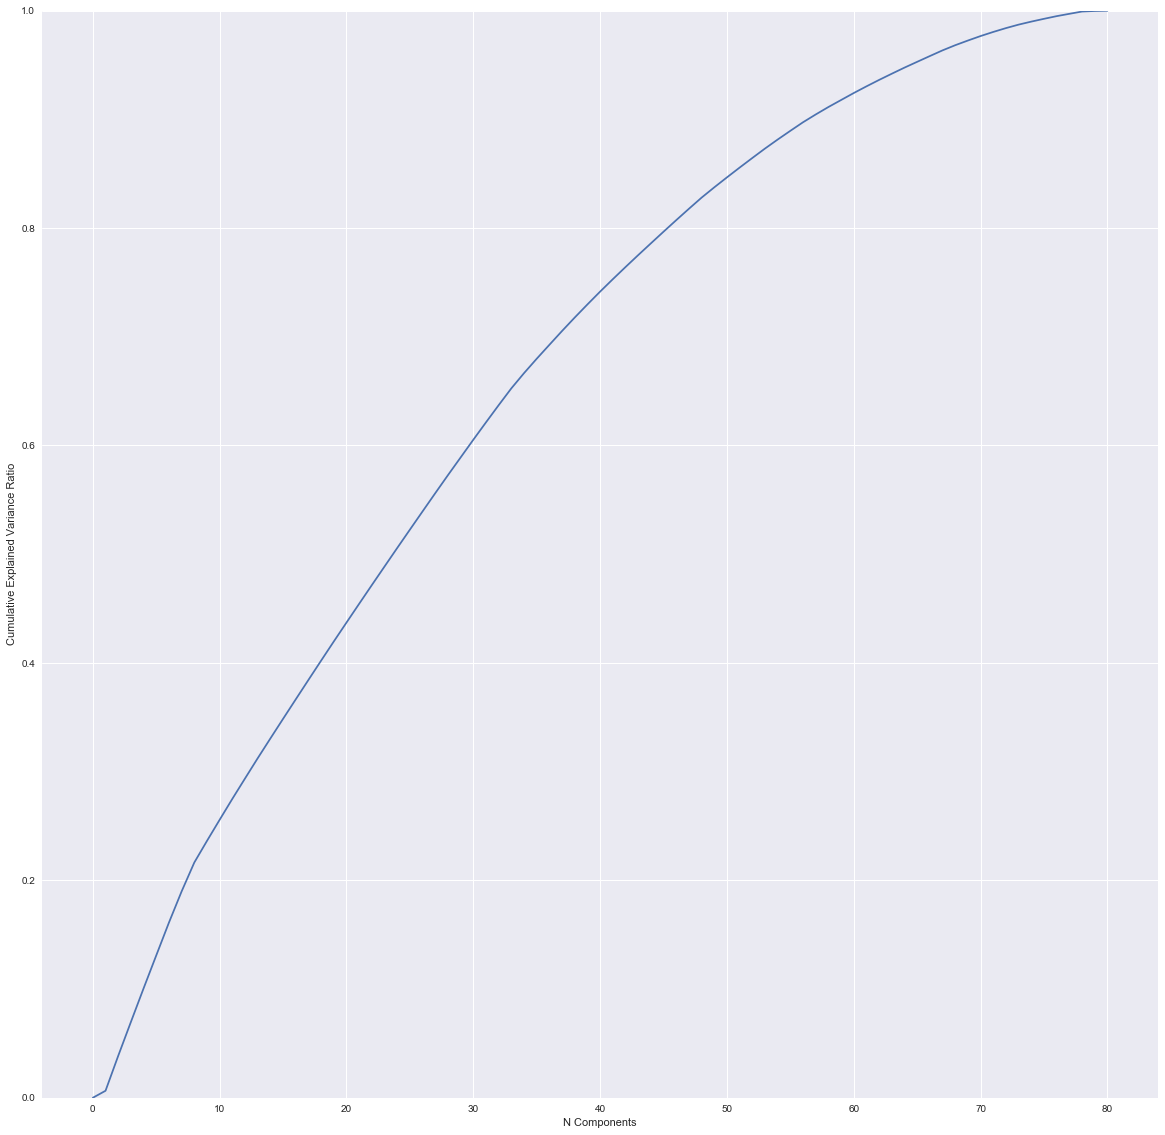

In [48]:
# Number of variables we will use in PCA
n = 80

# Running the PCA
pca = TruncatedSVD(n_components = n)
pca.fit(train_data_v2)

# Calculate sum of the EVR
evr = np.concatenate(([0], pca.explained_variance_ratio_))
sevr = np.cumsum(evr)
    
# Plotting cumulative sum
plt.plot(range(n + 1),sevr)
plt.xlabel('N Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.ylim([0,1])
plt.show()

It looks like the explained variance ratio tapers off at a dimensionality greater than 70. We can apply this to our model

In [49]:
# Number of variables we will use in PCA
n = 70

# Running the PCA
pca = TruncatedSVD(n_components = n)
pca.fit(train_data_v2)

after_transform_features_train = pca.transform(train_data_v2)
after_transform_features_dev = pca.transform(dev_data_v2)
after_transform_features_test = pca.transform(test_data_encoded_v2)

print('Shape of post PCA training dataset:',after_transform_features_train.shape)
print('Shape of post PCA dev dataset:',after_transform_features_dev.shape)
print('Shape of post PCA test dataset:',after_transform_features_test.shape)

Shape of post PCA training dataset: (702363, 70)
Shape of post PCA dev dataset: (175591, 70)
Shape of post PCA test dataset: (884262, 70)


## Multinomial Naive Bayes¶


In [36]:
# For V2 data
mnb_v2 = MultinomialNB()
alphas = {'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0,20,50,100,500,1000]}
mnb_v2_cv = GridSearchCV(estimator = mnb_v2, param_grid = alphas, cv = 3, scoring = 'f1_micro', n_jobs=-1)
nb_v2 = mnb_v2_cv.fit(train_data_v2, train_labels_v2)

In [38]:
# For V2 data

print('The best value for alpha (with feature engineering) is:', nb_v2.best_params_['alpha'])
print('Best score from grid search on training data set (with feature engineering):{fm}'.format(fm=round(nb_v2.best_score_,4)))


The best value for alpha (with feature engineering) is: 100
Best score from grid search on training data set (with feature engineering):0.2317


In [39]:
# For V2 data

best_alpha_v2 = nb_v2.best_params_['alpha']
mnb_v2_optimized = MultinomialNB(alpha = best_alpha_v2)
pred_labels_v2 = mnb_v2_optimized.fit(train_data_v2, train_labels_v2).predict(dev_data_v2)
mnb_v2_score = metrics.f1_score(dev_labels_v2, pred_labels_v2, average = 'micro')
print('The F1 score for a Multinomial Native Bayes model (with feature engineering) is {fm}'.format(fm=round(mnb_v2_score,4)))

The F1 score for a Multinomial Native Bayes model (with feature engineering) is 0.2315


### Now let's do the same thing with the PCA version

In [68]:
# We get an error from MNB if any values are negative. Therefore we first need to normalize the data

# Normalization methodology source: https://stackoverflow.com/questions/29661574/normalize-numpy-array-columns-in-python
norm_train = (after_transform_features_train - after_transform_features_train.min(axis = 0)) / after_transform_features_train.ptp(axis = 0)

# For V2 Normalized PCA data
mnb_v3 = MultinomialNB()
alphas = {'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0,20,50,100,500,1000]}
mnb_v3_cv = GridSearchCV(estimator = mnb_v3, param_grid = alphas, cv = 3, scoring = 'f1_micro', n_jobs=-1)
nb_v3 = mnb_v3_cv.fit(norm_train, train_labels_v2)

In [69]:
# For V2 Normalized PCA data

print('The best value for alpha (with feature engineering) is:', nb_v3.best_params_['alpha'])
print('Best score from grid search on training data set (with feature engineering):{fm}'.format(fm=round(nb_v3.best_score_,4)))


The best value for alpha (with feature engineering) is: 1e-07
Best score from grid search on training data set (with feature engineering):0.1993


In [70]:
# For V2 Normalized PCA data

norm_dev = (after_transform_features_dev - after_transform_features_dev.min(axis = 0)) / after_transform_features_dev.ptp(axis = 0)
norm_test = (after_transform_features_test - after_transform_features_test.min(axis = 0)) / after_transform_features_test.ptp(axis = 0)

best_alpha_v3 = nb_v3.best_params_['alpha']
mnb_v3_optimized = MultinomialNB(alpha = best_alpha_v3)
pred_labels_v3 = mnb_v3_optimized.fit(norm_train, train_labels_v2).predict(norm_dev)
mnb_v3_score = metrics.f1_score(dev_labels_v2, pred_labels_v3, average = 'micro')
print('The F1 score for a Multinomial Native Bayes model (with feature engineering) is {fm}'.format(fm=round(mnb_v3_score,4)))

The F1 score for a Multinomial Native Bayes model (with feature engineering) is 0.1989


Our score got worse with PCA. This is expected because we were losing some variation by trimming out several features here

## Analysis of Errors

In [97]:
cmatrix = confusion_matrix(dev_labels_v2, pred_labels_v2)

for i in range(cmatrix.shape[0]):
    row = cmatrix[i]
    index_max = row.argmax()
    total_preds = row.sum()
    print('Of', total_preds, data_classes_v2[i],'crimes,',row[index_max],'were predicted to be',data_classes_v2[index_max] )


Of 288 ARSON crimes, 135 were predicted to be LARCENY/THEFT
Of 15554 ASSAULT crimes, 8085 were predicted to be LARCENY/THEFT
Of 91 BAD CHECKS crimes, 62 were predicted to be LARCENY/THEFT
Of 46 BRIBERY crimes, 20 were predicted to be OTHER OFFENSES
Of 7352 BURGLARY crimes, 4699 were predicted to be LARCENY/THEFT
Of 868 DISORDERLY CONDUCT crimes, 394 were predicted to be LARCENY/THEFT
Of 461 DRIVING UNDER THE INFLUENCE crimes, 252 were predicted to be LARCENY/THEFT
Of 10769 DRUG/NARCOTIC crimes, 4469 were predicted to be LARCENY/THEFT
Of 827 DRUNKENNESS crimes, 525 were predicted to be LARCENY/THEFT
Of 212 EMBEZZLEMENT crimes, 139 were predicted to be LARCENY/THEFT
Of 52 EXTORTION crimes, 35 were predicted to be LARCENY/THEFT
Of 102 FAMILY OFFENSES crimes, 46 were predicted to be LARCENY/THEFT
Of 2082 FORGERY/COUNTERFEITING crimes, 1149 were predicted to be LARCENY/THEFT
Of 3362 FRAUD crimes, 2253 were predicted to be LARCENY/THEFT
Of 27 GAMBLING crimes, 13 were predicted to be OTHER OF

Our model is predicting more crimes are LARENCY THEFT than any other crimes. Perhaps we can first train our model to distinguish between Larency/ Theft crimes and all other crimes. Then, among those that are not Larency / Theft, we can further classify the crimes

## Logistic Regression¶


### L1 Logistic Regression¶


In [30]:
best_c = 0.1
best_solver = 'saga'
tol = 0.01
iterations = 10
penalty = 'l1'
multiclass = 'multinomial'

lr_l1_optimized = LogisticRegression(C = best_c, solver=best_solver,penalty=penalty, multi_class=multiclass,  
                                     random_state = random_seed, max_iter=iterations, tol = tol,n_jobs=-1,verbose=10)
pred_labels = lr_l1_optimized.fit(train_data_v2, train_labels_v2).predict(dev_data_v2)
l1_score = metrics.f1_score(dev_labels_v2, pred_labels, average = 'micro')


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 24 seconds


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.6s finished


In [31]:
print('The F1 score for a Logistic Regression model (using L1 errors) is %s'% (l1_score))

The F1 score for a Logistic Regression model (using L1 errors) is 0.23351994122705605


### L2 Logistic Regression¶


In [33]:
lr_l2 = LogisticRegression(penalty='l2', multi_class='multinomial',  random_state = 123, max_iter=100, tol = 0.001)

cv_params = {'C': [0.01, 0.1, 1.0, 10.0], 
            'solver' : ['newton-cg','sag','lbfgs']}

lr_l2_cv = GridSearchCV(estimator = lr_l2, param_grid = cv_params, cv = 3, scoring = 'f1_micro', n_jobs = -1, verbose = 10)
l2 = lr_l2_cv.fit(train_data_v2, train_labels_v2)
print('The best parameters for Logistic Regression (using L2 errors) are:', l2.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  17 out of  36 | elapsed: 14.3min remaining: 16.0min
[Parallel(n_jobs=-1)]: Done  21 out of  36 | elapsed: 16.9min remaining: 12.1min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed: 20.5min remaining:  9.0min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed: 23.7min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 47.8min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 127.9min finished


The best parameters for Logistic Regression (using L2 errors) are: {'C': 10.0, 'solver': 'sag'}


In [35]:
pred_labels_l2 = l2.predict(dev_data_v2)
l2_score = metrics.f1_score(dev_labels_v2, pred_labels_l2, average = 'micro')
print('The F1 score for a Logistic Regression model (using L2 errors) is %s'% (l2_score))

The F1 score for a Logistic Regression model (using L2 errors) is 0.23395276523284222


## KNN

In [ ]:
# baseline model is just a knn of 1 for just latitude and longitude
neighbors = 1
kn = KNeighborsClassifier(n_neighbors=neighbors,n_jobs=-1)
kn.fit(train_data_v2, train_labels_v2)

# Create predicted values
#preds_dev = kn.predict(dev_data)
score = kn.score(dev_data_v2, dev_labels_v2)
#proba = kn.predict_proba(dev_data)

print('Mean score from KNN with {nn} neighbors: {score}'.format(nn=neighbors, score=score))

## Decision trees

In [329]:
parameters={'min_samples_split' : range(10,50,5),'max_depth': range(2,10,2)}
clf_tree=DecisionTreeClassifier()
clf=GridSearchCV(clf_tree,parameters,cv=3,n_jobs=-1,verbose=1,iid=True)
clf_optim  = clf.fit(train_data_v2,train_labels_v2)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.3min finished


In [330]:
print(clf.cv_results_['params'][clf.best_index_])
print(clf_optim.best_score_)

{'max_depth': 8, 'min_samples_split': 20}
0.2515517869752397


## Random Forest

In [331]:
parameters={'n_estimators' : [10,15,20,50,100],
            'max_depth': range(2,10,2),
            'max_features': ['sqrt','log2', None],
            'min_samples_split' : range(100,500,50),
            'bootstrap': ['True','False']
           }
rfClf = RandomForestClassifier()
rfClf_search=GridSearchCV(rfClf,parameters,cv=3,n_jobs=-1,verbose=1)
rfClf_optim = rfClf_search.fit(train_data_v2,train_labels_v2)


Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 39.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 90.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 184.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 335.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 426.6min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 611.0min finished


In [335]:
print(rfClf_optim.cv_results_['params'][rfClf_optim.best_index_])
print(rfClf_optim.best_score_)

{'bootstrap': 'True', 'max_depth': 8, 'max_features': None, 'min_samples_split': 350, 'n_estimators': 20}
0.25504686681396777


In [338]:
# Choose the best model and train for predictions on test data

rfClf = RandomForestClassifier(bootstrap=True,max_depth=8,max_features=None,min_samples_split=350,n_estimators=20,n_jobs=-1,verbose=1)
rfClf.fit(train_data_v2,train_labels_v2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   46.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    2.0s finished


(884262,)


In [343]:
# Predict on test data

preds = rfClf.predict(test_data_encoded_v2)
print(preds.shape)
data_classes=data_classes_v2

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


(884262,)


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.9s finished


In [345]:
## Print formatted output for submission CSV

# Looking at format of output
#print(sample_submission.head())
print('sample submission shape', sample_submission.shape)

# Now put results in a dataframe 
all_ids = test["Id"].values

# From encoded categories, get normal labels
labeled_preds = [data_classes[i] for i in preds]

# Make dateframe
d = {'Id': all_ids, 'Label': labeled_preds}

# Make the results dummy columns
df = pd.DataFrame(data = d)
results = pd.get_dummies(df, prefix=[''],prefix_sep = '')

# To ensure we have all columns, copy data into the schema of sample_submission
submission = pd.DataFrame().reindex_like(sample_submission).fillna(0).astype(int)

col_names = list(results.columns.values)
for col in col_names:
    submission[col] = results[col]

    
print('final shape',submission.shape )
## Save the predictions to submission CSV file
submission.to_csv('submission.csv', index = False)

#print(submission)

sample submission shape (884262, 40)
final shape (884262, 40)


In [346]:
# Making a baseline submission that just takes the most frequent-occurring crime, and predicting all crimes in the test data frame are of that label

submission_no_ml = pd.DataFrame().reindex_like(sample_submission).fillna(0).astype(int)
submission_no_ml['Id'] = sample_submission['Id']
submission_no_ml['LARCENY/THEFT'] = 1
submission_no_ml.to_csv('baseline_submission_2.csv', index = False)

In [347]:
print(submission_no_ml.shape)
print(sample_submission.shape)
print(submission.shape)

(884262, 40)
(884262, 40)
(884262, 40)
